ROC AUC Explained: A Beginner’s Guide to Evaluating Classification Models

In [7]:
# logistic regression 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
df = pd.read_csv("dataset/HR-Employees.csv")

# Drop non-informative columns
df.drop(['EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1, inplace=True)

# Encode the target column
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Predict probabilities for the positive class
y_prob = model.predict_proba(X_test_scaled)[:, 1]


# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[237  10]
 [ 31  16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



Loading IBM HR dataset...
Dataset loaded successfully!
Dataset shape: (1470, 35)
Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   At

NameError: name 'roc_curve' is not defined

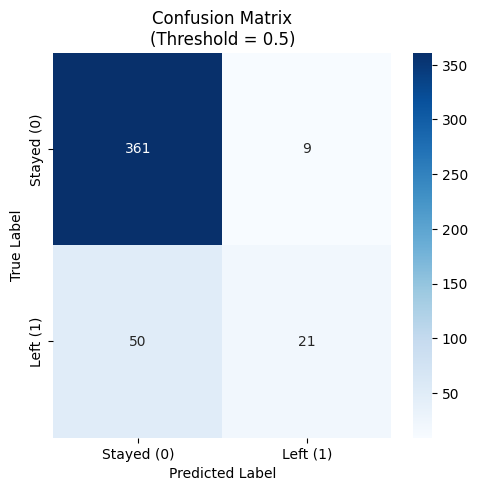

In [ ]:
from curses import window
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt as plt
import seaborn as sns

# Load the actual IBM HR dataset
print("Loading IBM HR dataset...")
try:
    df = pd.read_csv('dataset/HR-Employees.csv')
    print("Dataset loaded successfully!")
except:
    # Alternative method using window.fs API
    try:
        import asyncio
        async def read_csv():
            content = await window.fs.readFile('dataset/HR-Employees.csv', {'encoding': 'utf8'})
            from io import StringIO
            return pd.read_csv(StringIO(content))
        
        df = asyncio.run(read_csv())
        print("Dataset loaded using window.fs API!")
    except:
        print("Error: Could not load the dataset. Please ensure HREmployees.csv is in the current directory.")
        raise

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

print(f"\nAttrition distribution:")
print(df['Attrition'].value_counts())
attrition_rate = (df['Attrition'] == 'Yes').mean()
print(f"Attrition rate: {attrition_rate:.2%}")

print("\nFirst few rows:")
print(df.head())

# Data preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Convert Attrition to binary (Yes=1, No=0)
df['Attrition_binary'] = (df['Attrition'] == 'Yes').astype(int)
print(f"Attrition encoding: Yes=1, No=0")

# Handle missing values if any
print(f"Missing values per column:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

# Remove columns that won't be useful for prediction
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
# These columns have the same value for all employees or are just identifiers

# Encode categorical variables
categorical_cols = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                   'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

le_dict = {}
for col in categorical_cols:
    if col in df.columns and col != 'Attrition':  # Don't encode the target
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        le_dict[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Select features for modeling (excluding target and non-predictive columns)
feature_cols = [col for col in df.columns 
                if col not in ['Attrition', 'Attrition_binary'] + columns_to_drop
                and not col.endswith('_encoded')] + [col for col in df.columns if col.endswith('_encoded')]

# Remove any remaining non-numeric columns
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col in numeric_cols]

print(f"\nFeatures selected for modeling ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

X = df[feature_cols]
y = df['Attrition_binary']

print(f"Features selected: {len(feature_cols)}")
print(f"Target variable distribution:")
print(y.value_counts(normalize=True))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
print("\n" + "="*50)
print("LOGISTIC REGRESSION MODELING")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Model training completed!")

# Get probability predictions
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Probability scores generated for {len(y_test_proba)} employees")
print(f"Probability range: {y_test_proba.min():.3f} to {y_test_proba.max():.3f}")

# Show some example probability scores
print("\nSample probability predictions:")
sample_indices = y_test.index[:10]  # Get actual indices
sample_df = pd.DataFrame({
    'Employee_ID': sample_indices,
    'Actual_Attrition': y_test.iloc[:10].values,
    'Predicted_Probability': y_test_proba[:10],
    'Predicted_Class': (y_test_proba[:10] >= 0.5).astype(int)
})
print(sample_df.round(3))

# Apply default threshold of 0.5
print("\n" + "="*50)
print("PREDICTIONS WITH 0.5 THRESHOLD")
print("="*50)

threshold = 0.5
y_pred = (y_test_proba >= threshold).astype(int)

print(f"Using threshold: {threshold}")
print(f"Employees predicted to leave (probability >= {threshold}): {sum(y_pred)}")
print(f"Employees predicted to stay (probability < {threshold}): {sum(1-y_pred)}")

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Create a more detailed confusion matrix display
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed (0)', 'Left (1)'], 
            yticklabels=['Stayed (0)', 'Left (1)'])
plt.title('Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted to stay): {tn}")
print(f"False Positives (Incorrectly predicted to leave): {fp}")
print(f"False Negatives (Incorrectly predicted to stay): {fn}")
print(f"True Positives (Correctly predicted to leave): {tp}")

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

report = classification_report(y_test, y_pred, target_names=['Stayed', 'Left'])
print(report)

# Additional metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.3f} ({accuracy:.1%})")
print(f"Precision (for 'Left'): {precision:.3f} ({precision:.1%})")
print(f"Recall/Sensitivity (for 'Left'): {recall:.3f} ({recall:.1%})")
print(f"Specificity (for 'Stayed'): {specificity:.3f} ({specificity:.1%})")

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {auc_score:.3f}")

# WHY ACCURACY IS MISLEADING
print("\n" + "="*70)
print("🚨 WHY ACCURACY IS MISLEADING IN THIS CASE")
print("="*70)

total_employees = len(y_test)
actual_leavers = sum(y_test)
actual_stayers = total_employees - actual_leavers
predicted_leavers = sum(y_pred)
predicted_stayers = total_employees - predicted_leavers

print(f"Dataset Composition:")
print(f"  • Total employees in test set: {total_employees}")
print(f"  • Actual employees who left: {actual_leavers} ({actual_leavers/total_employees:.1%})")
print(f"  • Actual employees who stayed: {actual_stayers} ({actual_stayers/total_employees:.1%})")
print(f"  • This is an IMBALANCED dataset!")

print(f"\nModel Performance Breakdown:")
print(f"  • True Positives (correctly identified leavers): {tp}")
print(f"  • False Negatives (missed leavers): {fn}")
print(f"  • True Negatives (correctly identified stayers): {tn}")
print(f"  • False Positives (false alarms): {fp}")

print(f"\n🔍 THE ACCURACY TRAP:")
print(f"  • Accuracy = {accuracy:.1%} sounds great!")
print(f"  • But recall = {recall:.1%} means we're missing {(1-recall):.1%} of employees who actually leave")
print(f"  • Out of {actual_leavers} employees who actually left, we only caught {tp}")

print(f"\n💡 WHY THIS HAPPENS:")
print(f"  • The model gets {tn} 'stayed' predictions correct easily (majority class)")
print(f"  • These {tn} correct 'stayed' predictions inflate the accuracy")
print(f"  • But the model struggles with the minority class (leavers)")
print(f"  • Missing {fn} out of {actual_leavers} leavers is a huge business problem!")

# Demonstrate the "naive" baseline
naive_accuracy = max(actual_stayers, actual_leavers) / total_employees
print(f"\n🎯 BASELINE COMPARISON:")
print(f"  • If we simply predicted 'everyone stays': {naive_accuracy:.1%} accuracy")
print(f"  • Our model's {accuracy:.1%} accuracy isn't much better!")
print(f"  • But our model has terrible recall: {recall:.1%}")

print(f"\n💰 BUSINESS IMPACT:")
print(f"  • High accuracy seems good, but we're failing at the main goal")
print(f"  • Missing {fn} employees who will leave = lost talent & replacement costs")
print(f"  • Low recall means HR can't take preventive action")
print(f"  • This is why precision and recall matter more than accuracy!")

# ROC Curve Analysis
print("\n" + "="*50)
print("ROC CURVE ANALYSIS")
print("="*50)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC: {roc_auc:.2f}")

# Interpret AUC score
if roc_auc >= 0.9:
    interpretation = "Excellent"
elif roc_auc >= 0.8:
    interpretation = "Good"
elif roc_auc >= 0.7:
    interpretation = "Fair"
elif roc_auc >= 0.6:
    interpretation = "Poor"
else:
    interpretation = "Very Poor"

print(f"AUC Interpretation: {interpretation}")
print(f"The model has a {roc_auc:.1%} chance of correctly ranking a random leaver higher than a random stayer")

# Create ROC curve visualization
plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2, color='blue')
plt.plot([0,1], [0,1], 'k--', label="Random guess (AUC = 0.5)", linewidth=1)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Logistic Regression\n(HR Dataset)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Add annotation about what FPR and TPR mean
plt.text(0.6, 0.2, 'FPR = FP/(FP+TN)\n(False Alarm Rate)', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
plt.text(0.1, 0.7, 'TPR = TP/(TP+FN)\n(Recall/Sensitivity)', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# Confusion Matrix (from earlier)
plt.subplot(1, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed (0)', 'Left (1)'], 
            yticklabels=['Stayed (0)', 'Left (1)'])
plt.title('Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Probability distribution visualization
plt.subplot(1, 3, 3)
plt.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, label='Stayed (Actual)', color='blue')
plt.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, label='Left (Actual)', color='red')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed ROC Analysis
print(f"\n📊 ROC CURVE INSIGHTS:")
print(f"  • AUC = {roc_auc:.3f} means the model discriminates well between classes")
print(f"  • Perfect model would have AUC = 1.0 (curve hugs top-left corner)")
print(f"  • Random guessing gives AUC = 0.5 (diagonal line)")
print(f"  • Current model is {interpretation.lower()} at ranking employees by attrition risk")

# Find optimal threshold using ROC curve
# Optimal threshold minimizes distance to top-left corner
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"\n🎯 OPTIMAL THRESHOLD FROM ROC:")
print(f"  • Optimal threshold: {optimal_threshold:.3f}")
print(f"  • At this threshold: TPR = {optimal_tpr:.3f}, FPR = {optimal_fpr:.3f}")

# Compare different thresholds with their ROC points
print(f"\n🔍 THRESHOLD ANALYSIS:")
test_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for thresh in test_thresholds:
    # Find closest threshold in ROC curve
    idx = np.argmin(np.abs(thresholds - thresh))
    thresh_fpr = fpr[idx]
    thresh_tpr = tpr[idx]
    
    # Calculate predictions for this threshold
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel()
    
    acc_t = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    rec_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    
    print(f"  Threshold {thresh:.1f}: Accuracy={acc_t:.2f}, Precision={prec_t:.2f}, Recall={rec_t:.2f}, FPR={thresh_fpr:.2f}")

print(f"\n💡 ROC CURVE TELLS US:")
print(f"  • Trade-off between True Positive Rate (catching leavers) and False Positive Rate (false alarms)")
print(f"  • Steeper curve at start = good performance at low false positive rates")
print(f"  • Area under curve summarizes overall discriminative ability")
print(f"  • Unlike accuracy, AUC is not misleading for imbalanced datasets!")

# Feature importance
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Show impact of different thresholds
print("\n" + "="*50)
print("IMPACT OF DIFFERENT THRESHOLDS")
print("="*50)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    pred = (y_test_proba >= thresh).astype(int)
    cm_temp = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm_temp.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Predicted_Positive': tp + fp
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df)

print(f"\n📊 BETTER METRICS FOR IMBALANCED DATA:")
print(f"  • F1-Score: {2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0:.3f}")
print(f"  • ROC AUC: {auc_score:.3f} (measures overall discrimination ability)")
print(f"  • Precision-Recall AUC would be more informative than accuracy")
print(f"  • Consider adjusting threshold to improve recall!")

print(f"\n🎛️  THRESHOLD ADJUSTMENT NEEDED:")
print(f"  • Current 0.5 threshold optimizes for accuracy")
print(f"  • Lower threshold (e.g., 0.3) would catch more leavers (higher recall)")
print(f"  • Trade-off: Lower precision but better at identifying at-risk employees")
print(f"  • For HR: Better to have false alarms than miss departing employees!")

# Demonstrate different threshold
better_threshold = 0.3
y_pred_better = (y_test_proba >= better_threshold).astype(int)
cm_better = confusion_matrix(y_test, y_pred_better)
tn_b, fp_b, fn_b, tp_b = cm_better.ravel()

accuracy_b = (tp_b + tn_b) / (tp_b + tn_b + fp_b + fn_b)
precision_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
recall_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0

print(f"\n🔄 WITH LOWER THRESHOLD ({better_threshold}):")
print(f"  • Accuracy: {accuracy_b:.1%} (lower - but that's OK!)")
print(f"  • Recall: {recall_b:.1%} (much better - caught more leavers!)")
print(f"  • Precision: {precision_b:.1%} (lower - more false alarms)")
print(f"  • Missed leavers: {fn_b} (down from {fn})")

print(f"\n✅ KEY TAKEAWAY:")
print(f"  • Accuracy is misleading when classes are imbalanced")
print(f"  • Focus on metrics that matter for your business problem")
print(f"  • In HR: Recall is often more important than accuracy")
print(f"  • Always consider the cost of false negatives vs false positives")

# checking the probabilties 

Loading IBM HR dataset...
Dataset loaded successfully!
Dataset shape: (1470, 35)
Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   At

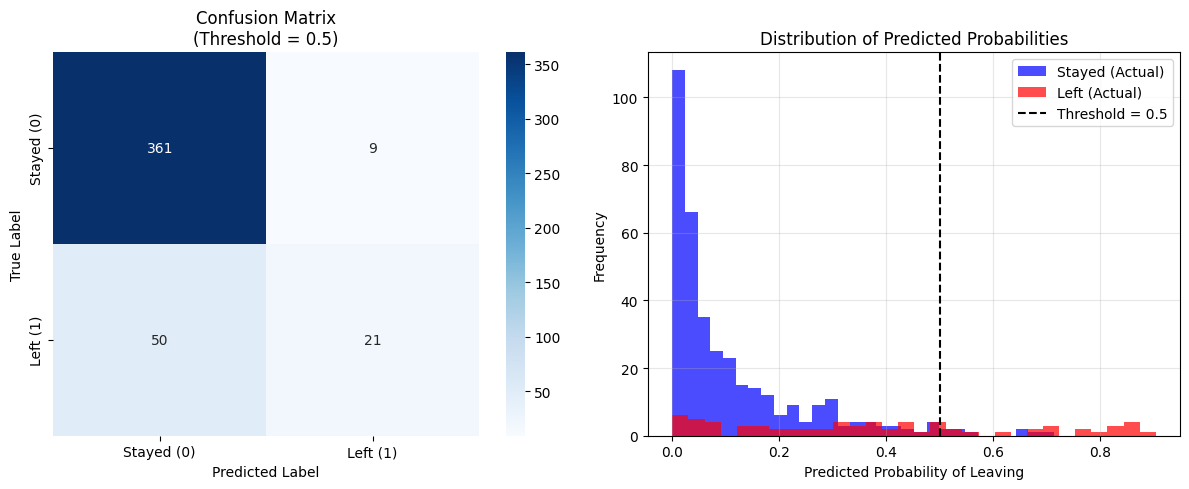


FEATURE IMPORTANCE
Top 10 Most Important Features:
                    Feature  Coefficient  Abs_Coefficient
29         OverTime_encoded     0.782649         0.782649
21  YearsSinceLastPromotion     0.549332         0.549332
11       NumCompaniesWorked     0.471419         0.471419
24       Department_encoded     0.447859         0.447859
20       YearsInCurrentRole    -0.431141         0.431141
4   EnvironmentSatisfaction    -0.415354         0.415354
9             MonthlyIncome    -0.415038         0.415038
8           JobSatisfaction    -0.410156         0.410156
0                       Age    -0.403114         0.403114
22     YearsWithCurrManager    -0.390248         0.390248

IMPACT OF DIFFERENT THRESHOLDS
   Threshold  Accuracy  Precision    Recall  Predicted_Positive
0        0.3  0.852608   0.538462  0.591549                  78
1        0.4  0.863946   0.607843  0.436620                  51
2        0.5  0.866213   0.700000  0.295775                  30
3        0.6  0.868481

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual IBM HR dataset
print("Loading IBM HR dataset...")
try:
    df = pd.read_csv('dataset/HR-Employees.csv')
    print("Dataset loaded successfully!")
except:
    # Alternative method using window.fs API
    try:
        import asyncio
        async def read_csv():
            content = await window.fs.readFile('HREmployees.csv', {'encoding': 'utf8'})
            from io import StringIO
            return pd.read_csv(StringIO(content))
        
        df = asyncio.run(read_csv())
        print("Dataset loaded using window.fs API!")
    except:
        print("Error: Could not load the dataset. Please ensure HREmployees.csv is in the current directory.")
        raise

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

print(f"\nAttrition distribution:")
print(df['Attrition'].value_counts())
attrition_rate = (df['Attrition'] == 'Yes').mean()
print(f"Attrition rate: {attrition_rate:.2%}")

print("\nFirst few rows:")
print(df.head())

# Data preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Convert Attrition to binary (Yes=1, No=0)
df['Attrition_binary'] = (df['Attrition'] == 'Yes').astype(int)
print(f"Attrition encoding: Yes=1, No=0")

# Handle missing values if any
print(f"Missing values per column:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

# Remove columns that won't be useful for prediction
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
# These columns have the same value for all employees or are just identifiers

# Encode categorical variables
categorical_cols = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                   'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

le_dict = {}
for col in categorical_cols:
    if col in df.columns and col != 'Attrition':  # Don't encode the target
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        le_dict[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Select features for modeling (excluding target and non-predictive columns)
feature_cols = [col for col in df.columns 
                if col not in ['Attrition', 'Attrition_binary'] + columns_to_drop
                and not col.endswith('_encoded')] + [col for col in df.columns if col.endswith('_encoded')]

# Remove any remaining non-numeric columns
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col in numeric_cols]

print(f"\nFeatures selected for modeling ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

X = df[feature_cols]
y = df['Attrition_binary']

print(f"Features selected: {len(feature_cols)}")
print(f"Target variable distribution:")
print(y.value_counts(normalize=True))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
print("\n" + "="*50)
print("LOGISTIC REGRESSION MODELING")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Model training completed!")

# Get probability predictions
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Probability scores generated for {len(y_test_proba)} employees")
print(f"Probability range: {y_test_proba.min():.3f} to {y_test_proba.max():.3f}")

# Show some example probability scores
print("\nSample probability predictions:")
sample_indices = y_test.index[:10]  # Get actual indices
sample_df = pd.DataFrame({
    'Employee_ID': sample_indices,
    'Actual_Attrition': y_test.iloc[:10].values,
    'Predicted_Probability': y_test_proba[:10],
    'Predicted_Class': (y_test_proba[:10] >= 0.5).astype(int)
})
print(sample_df.round(3))

# Apply default threshold of 0.5
print("\n" + "="*50)
print("PREDICTIONS WITH 0.5 THRESHOLD")
print("="*50)

threshold = 0.5
y_pred = (y_test_proba >= threshold).astype(int)

print(f"Using threshold: {threshold}")
print(f"Employees predicted to leave (probability >= {threshold}): {sum(y_pred)}")
print(f"Employees predicted to stay (probability < {threshold}): {sum(1-y_pred)}")

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Create a more detailed confusion matrix display
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed (0)', 'Left (1)'], 
            yticklabels=['Stayed (0)', 'Left (1)'])
plt.title('Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted to stay): {tn}")
print(f"False Positives (Incorrectly predicted to leave): {fp}")
print(f"False Negatives (Incorrectly predicted to stay): {fn}")
print(f"True Positives (Correctly predicted to leave): {tp}")

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

report = classification_report(y_test, y_pred, target_names=['Stayed', 'Left'])
print(report)

# Additional metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (for 'Left'): {precision:.3f}")
print(f"Recall/Sensitivity (for 'Left'): {recall:.3f}")
print(f"Specificity (for 'Stayed'): {specificity:.3f}")

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {auc_score:.3f}")

# Probability distribution visualization
plt.subplot(1, 2, 2)
plt.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, label='Stayed (Actual)', color='blue')
plt.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, label='Left (Actual)', color='red')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Show impact of different thresholds
print("\n" + "="*50)
print("IMPACT OF DIFFERENT THRESHOLDS")
print("="*50)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    pred = (y_test_proba >= thresh).astype(int)
    cm_temp = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm_temp.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Predicted_Positive': tp + fp
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df)

print(f"\nNote: The default threshold of 0.5 represents the decision boundary where:")
print(f"- Probability >= 0.5: Employee predicted to LEAVE")
print(f"- Probability < 0.5: Employee predicted to STAY")
print(f"\nThis threshold can be adjusted based on business requirements:")
print(f"- Lower threshold: More sensitive to potential leavers (higher recall)")
print(f"- Higher threshold: More conservative predictions (higher precision)")

Loading IBM HR dataset...
Dataset loaded successfully!
Dataset shape: (1470, 35)
Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   At

/home/user/hackathons/hackathon_env/lib/python3.12/site-packages/matplotlib/transforms.py:109: RuntimeWarning: coroutine 'read_csv' was never awaited
  def __init__(self, shorthand_name=None):


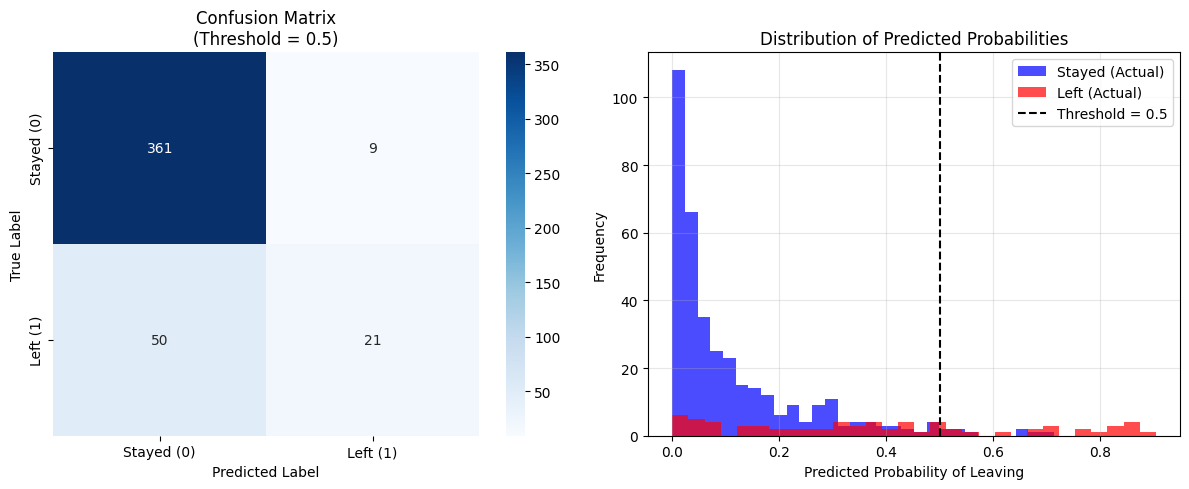


FEATURE IMPORTANCE
Top 10 Most Important Features:
                    Feature  Coefficient  Abs_Coefficient
29         OverTime_encoded     0.782649         0.782649
21  YearsSinceLastPromotion     0.549332         0.549332
11       NumCompaniesWorked     0.471419         0.471419
24       Department_encoded     0.447859         0.447859
20       YearsInCurrentRole    -0.431141         0.431141
4   EnvironmentSatisfaction    -0.415354         0.415354
9             MonthlyIncome    -0.415038         0.415038
8           JobSatisfaction    -0.410156         0.410156
0                       Age    -0.403114         0.403114
22     YearsWithCurrManager    -0.390248         0.390248

IMPACT OF DIFFERENT THRESHOLDS
   Threshold  Accuracy  Precision    Recall  Predicted_Positive
0        0.3  0.852608   0.538462  0.591549                  78
1        0.4  0.863946   0.607843  0.436620                  51
2        0.5  0.866213   0.700000  0.295775                  30
3        0.6  0.868481

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual IBM HR dataset
print("Loading IBM HR dataset...")
try:
    df = pd.read_csv('dataset/HR-Employees.csv')
    print("Dataset loaded successfully!")
except:
    # Alternative method using window.fs API
    try:
        import asyncio
        async def read_csv():
            content = await window.fs.readFile('HREmployees.csv', {'encoding': 'utf8'})
            from io import StringIO
            return pd.read_csv(StringIO(content))
        
        df = asyncio.run(read_csv())
        print("Dataset loaded using window.fs API!")
    except:
        print("Error: Could not load the dataset. Please ensure HREmployees.csv is in the current directory.")
        raise

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

print(f"\nAttrition distribution:")
print(df['Attrition'].value_counts())
attrition_rate = (df['Attrition'] == 'Yes').mean()
print(f"Attrition rate: {attrition_rate:.2%}")

print("\nFirst few rows:")
print(df.head())

# Data preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Convert Attrition to binary (Yes=1, No=0)
df['Attrition_binary'] = (df['Attrition'] == 'Yes').astype(int)
print(f"Attrition encoding: Yes=1, No=0")

# Handle missing values if any
print(f"Missing values per column:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

# Remove columns that won't be useful for prediction
columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
# These columns have the same value for all employees or are just identifiers

# Encode categorical variables
categorical_cols = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                   'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

le_dict = {}
for col in categorical_cols:
    if col in df.columns and col != 'Attrition':  # Don't encode the target
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        le_dict[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Select features for modeling (excluding target and non-predictive columns)
feature_cols = [col for col in df.columns 
                if col not in ['Attrition', 'Attrition_binary'] + columns_to_drop
                and not col.endswith('_encoded')] + [col for col in df.columns if col.endswith('_encoded')]

# Remove any remaining non-numeric columns
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col in numeric_cols]

print(f"\nFeatures selected for modeling ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

X = df[feature_cols]
y = df['Attrition_binary']

print(f"Features selected: {len(feature_cols)}")
print(f"Target variable distribution:")
print(y.value_counts(normalize=True))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
print("\n" + "="*50)
print("LOGISTIC REGRESSION MODELING")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Model training completed!")

# Get probability predictions
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Probability scores generated for {len(y_test_proba)} employees")
print(f"Probability range: {y_test_proba.min():.3f} to {y_test_proba.max():.3f}")

# Show some example probability scores
print("\nSample probability predictions:")
sample_indices = y_test.index[:10]  # Get actual indices
sample_df = pd.DataFrame({
    'Employee_ID': sample_indices,
    'Actual_Attrition': y_test.iloc[:10].values,
    'Predicted_Probability': y_test_proba[:10],
    'Predicted_Class': (y_test_proba[:10] >= 0.5).astype(int)
})
print(sample_df.round(3))

# Apply default threshold of 0.5
print("\n" + "="*50)
print("PREDICTIONS WITH 0.5 THRESHOLD")
print("="*50)

threshold = 0.5
y_pred = (y_test_proba >= threshold).astype(int)

print(f"Using threshold: {threshold}")
print(f"Employees predicted to leave (probability >= {threshold}): {sum(y_pred)}")
print(f"Employees predicted to stay (probability < {threshold}): {sum(1-y_pred)}")

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Create a more detailed confusion matrix display
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed (0)', 'Left (1)'], 
            yticklabels=['Stayed (0)', 'Left (1)'])
plt.title('Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted to stay): {tn}")
print(f"False Positives (Incorrectly predicted to leave): {fp}")
print(f"False Negatives (Incorrectly predicted to stay): {fn}")
print(f"True Positives (Correctly predicted to leave): {tp}")

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

report = classification_report(y_test, y_pred, target_names=['Stayed', 'Left'])
print(report)

# Additional metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.3f} ({accuracy:.1%})")
print(f"Precision (for 'Left'): {precision:.3f} ({precision:.1%})")
print(f"Recall/Sensitivity (for 'Left'): {recall:.3f} ({recall:.1%})")
print(f"Specificity (for 'Stayed'): {specificity:.3f} ({specificity:.1%})")

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {auc_score:.3f}")

# WHY ACCURACY IS MISLEADING
print("\n" + "="*70)
print("🚨 WHY ACCURACY IS MISLEADING IN THIS CASE")
print("="*70)

total_employees = len(y_test)
actual_leavers = sum(y_test)
actual_stayers = total_employees - actual_leavers
predicted_leavers = sum(y_pred)
predicted_stayers = total_employees - predicted_leavers

print(f"Dataset Composition:")
print(f"  • Total employees in test set: {total_employees}")
print(f"  • Actual employees who left: {actual_leavers} ({actual_leavers/total_employees:.1%})")
print(f"  • Actual employees who stayed: {actual_stayers} ({actual_stayers/total_employees:.1%})")
print(f"  • This is an IMBALANCED dataset!")

print(f"\nModel Performance Breakdown:")
print(f"  • True Positives (correctly identified leavers): {tp}")
print(f"  • False Negatives (missed leavers): {fn}")
print(f"  • True Negatives (correctly identified stayers): {tn}")
print(f"  • False Positives (false alarms): {fp}")

print(f"\n🔍 THE ACCURACY TRAP:")
print(f"  • Accuracy = {accuracy:.1%} sounds great!")
print(f"  • But recall = {recall:.1%} means we're missing {(1-recall):.1%} of employees who actually leave")
print(f"  • Out of {actual_leavers} employees who actually left, we only caught {tp}")

print(f"\n💡 WHY THIS HAPPENS:")
print(f"  • The model gets {tn} 'stayed' predictions correct easily (majority class)")
print(f"  • These {tn} correct 'stayed' predictions inflate the accuracy")
print(f"  • But the model struggles with the minority class (leavers)")
print(f"  • Missing {fn} out of {actual_leavers} leavers is a huge business problem!")

# Demonstrate the "naive" baseline
naive_accuracy = max(actual_stayers, actual_leavers) / total_employees
print(f"\n🎯 BASELINE COMPARISON:")
print(f"  • If we simply predicted 'everyone stays': {naive_accuracy:.1%} accuracy")
print(f"  • Our model's {accuracy:.1%} accuracy isn't much better!")
print(f"  • But our model has terrible recall: {recall:.1%}")

print(f"\n💰 BUSINESS IMPACT:")
print(f"  • High accuracy seems good, but we're failing at the main goal")
print(f"  • Missing {fn} employees who will leave = lost talent & replacement costs")
print(f"  • Low recall means HR can't take preventive action")
print(f"  • This is why precision and recall matter more than accuracy!")

# Probability distribution visualization
plt.subplot(1, 2, 2)
plt.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, label='Stayed (Actual)', color='blue')
plt.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, label='Left (Actual)', color='red')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Show impact of different thresholds
print("\n" + "="*50)
print("IMPACT OF DIFFERENT THRESHOLDS")
print("="*50)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    pred = (y_test_proba >= thresh).astype(int)
    cm_temp = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm_temp.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Predicted_Positive': tp + fp
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df)

print(f"\n📊 BETTER METRICS FOR IMBALANCED DATA:")
print(f"  • F1-Score: {2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0:.3f}")
print(f"  • ROC AUC: {auc_score:.3f} (measures overall discrimination ability)")
print(f"  • Precision-Recall AUC would be more informative than accuracy")
print(f"  • Consider adjusting threshold to improve recall!")

print(f"\n🎛️  THRESHOLD ADJUSTMENT NEEDED:")
print(f"  • Current 0.5 threshold optimizes for accuracy")
print(f"  • Lower threshold (e.g., 0.3) would catch more leavers (higher recall)")
print(f"  • Trade-off: Lower precision but better at identifying at-risk employees")
print(f"  • For HR: Better to have false alarms than miss departing employees!")

# Demonstrate different threshold
better_threshold = 0.3
y_pred_better = (y_test_proba >= better_threshold).astype(int)
cm_better = confusion_matrix(y_test, y_pred_better)
tn_b, fp_b, fn_b, tp_b = cm_better.ravel()

accuracy_b = (tp_b + tn_b) / (tp_b + tn_b + fp_b + fn_b)
precision_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
recall_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0

print(f"\n🔄 WITH LOWER THRESHOLD ({better_threshold}):")
print(f"  • Accuracy: {accuracy_b:.1%} (lower - but that's OK!)")
print(f"  • Recall: {recall_b:.1%} (much better - caught more leavers!)")
print(f"  • Precision: {precision_b:.1%} (lower - more false alarms)")
print(f"  • Missed leavers: {fn_b} (down from {fn})")

print(f"\n✅ KEY TAKEAWAY:")
print(f"  • Accuracy is misleading when classes are imbalanced")
print(f"  • Focus on metrics that matter for your business problem")
print(f"  • In HR: Recall is often more important than accuracy")
print(f"  • Always consider the cost of false negatives vs false positives")